# Build a Delft-FIAT model anywhere in the world with OSM and JRC data

This notebook demonstrates how to set up a Delft-FIAT model anywhere in the world. As an example we will create a model for the city of Kingston upon Hull, UK, in the Humber delta. The relevant data will be taken from [OpenStreetMap (OSM)](https://www.openstreetmap.org) and the [global flood vulnerability datasets from JRC](https://publications.jrc.ec.europa.eu/repository/handle/JRC105688). Both the data sources and the region of interest (the model domain) can be changed according to the user's wishes.

*Disclaimer: The outcomes of this model are not validated*

## **Step 0**: Import required packages
First we need to import the necessary python packages.

In [1]:
# import required packages
import os
from hydromt_fiat.fiat import FiatModel
from hydromt.log import setuplog
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import shutil
%matplotlib inline

## **Step 1a**: Configure - initialization
The first step is to set up the configuration needed to initialize the FIAT model. Begin by specifying where to save the model with the following parameters:
- `model_root`: the path to a folder where the model should be saved in
- `model_name`: the name of the model

In [59]:
model_root = 'FIAT_database'  # where to save the FIAT model
model_name = "example" # name of the case study

We need some additional utilities, such as a data catalog telling the model where to find the data and a logger keeping track of changes to the model. Specifying these, the parameters below don't need to be altered.
- `model_folder`: the full path to the to be created model folder (`model_root` + `model_name`)
- `data_catalog`: the relative path to the HydroMT-FIAT global data catalog. Make sure the root specified in the catalog is correct
- `logger_name`: the log-file name. A logger object is also initialized below

In [60]:
model_folder = Path(model_root) / model_name  # full path to model folder
data_catalog = Path(os.path.abspath("")) / "data" / "hydromt_fiat_catalog_global.yml"  # path to data catalog relative to this notebook
logger_name = "hydromt_fiat"  # name of the logger
logger = setuplog(logger_name, log_level=10) # setup logger

2024-02-29 08:25:11,681 - hydromt_fiat - log - INFO - HydroMT version: 0.8.0


INFO:hydromt_fiat:HydroMT version: 0.8.0


## **Step 1b**: Configure - model setup
Next we need to set up the sptial boundaries, or domain, of the model.

A useful tool for this is http://geojson.io. Here you can draw a polygon on the map and export it to a geojson file, or copy the GeoJSON description directly into the `area_of_interest` parameter. In this example, we load in a GeoJSON file with our model domain.

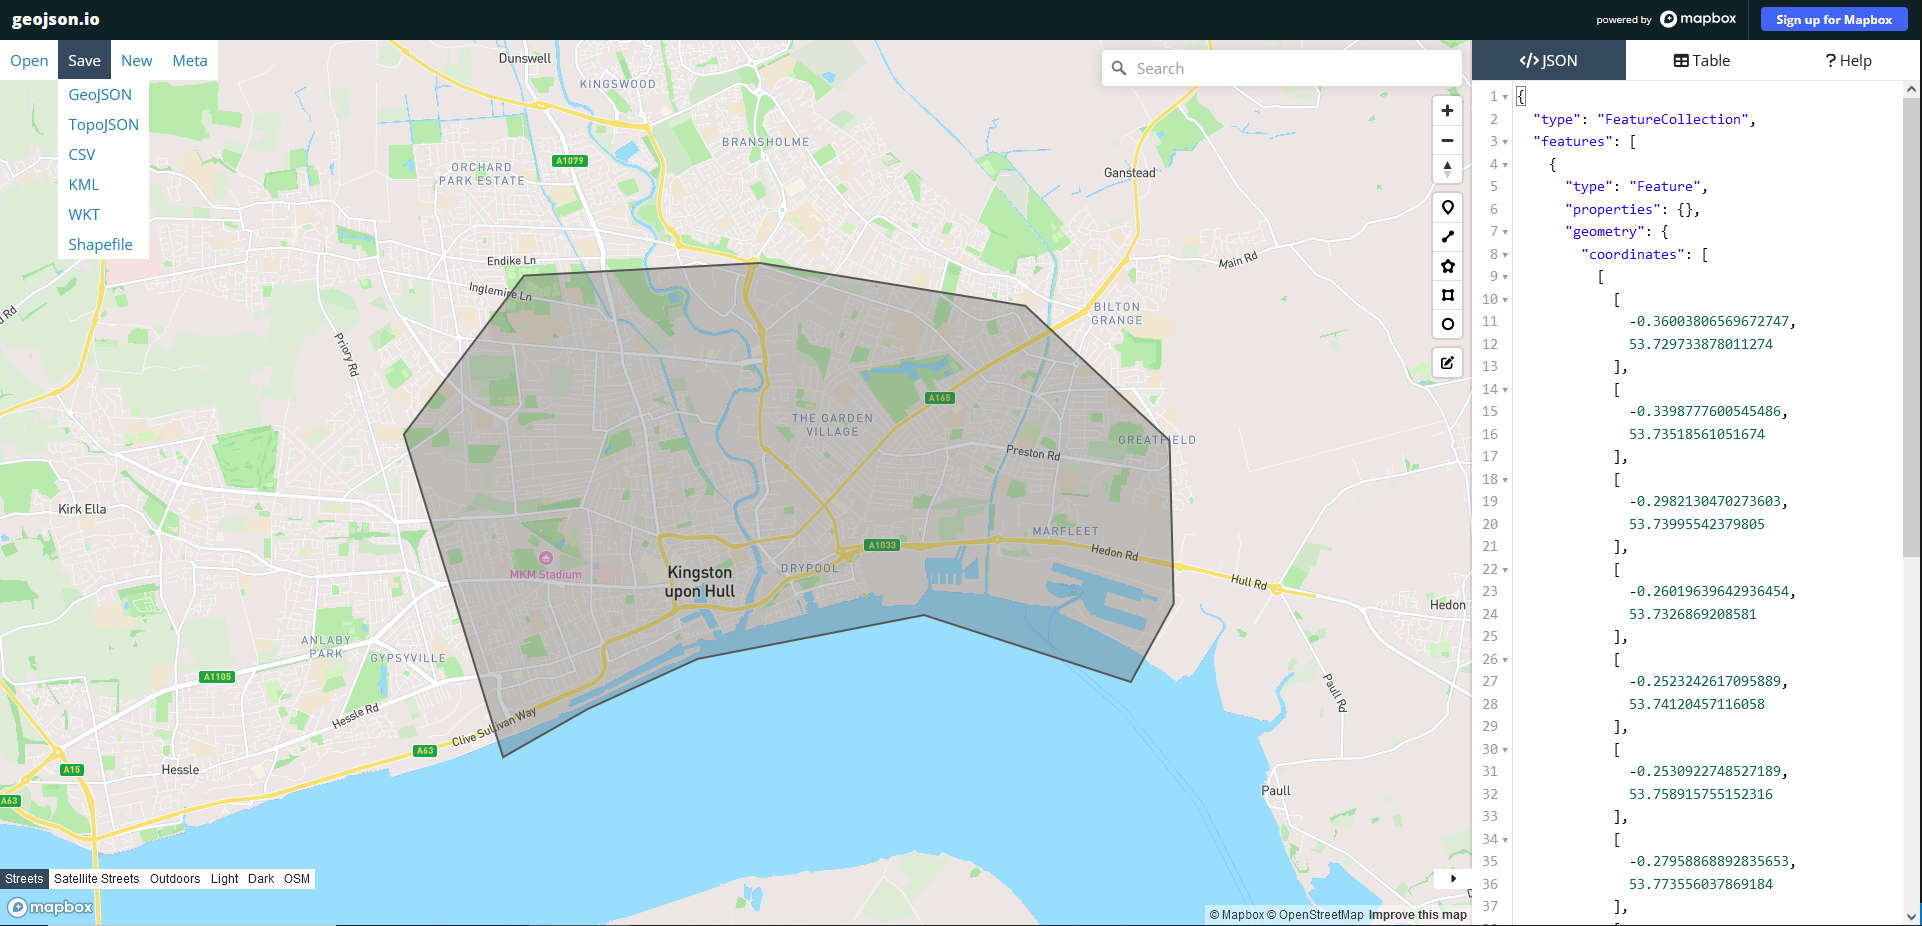

In [61]:
domain_fn = Path('./data/KingstonUponHull_domain.geojson')
region = gpd.read_file(domain_fn)

In [ ]:
# # The code block below can be used to define a custom region of interest
# # by assigning the GeoJSON description to the area_of_interest variable

# area_of_interest = {
#     "type": "FeatureCollection",
#     "features": [
#         {
#             "type": "Feature",
#             "properties": {},
#             "geometry": {
#                 "coordinates": [
#                     [
#                         [32.54354450016967, 0.3260186123942219],
#                         [32.54354450016967, 0.28330087448348706],
#                         [32.59681776425123, 0.28330087448348706],
#                         [32.59681776425123, 0.3260186123942219],
#                         [32.54354450016967, 0.3260186123942219],
#                     ]
#                 ],
#                 "type": "Polygon",
#             },
#         }
#     ],
# }
# region = gpd.GeoDataFrame.from_features(area_of_interest, crs="EPSG:4326")

To assign the relevant maximum potential damages and vulnerability curves, HydroMT-FIAT must know in which country and continent the domain is located. This will be automated in a later version, but for now we specify this manually:
- `continent`: the name of the continent where your area of interest is located. Please choose one of the following: Europe, North America, Central America, South America, Asia, Africa, Oceania, or Global
- `country`: the name of the country where your area of interest is located. Note that not all countries are included in the JRC database.

In [63]:
continent = "Europe"
country = "United Kingdom"

Next, we need to specify properties of the various dataset. For the vulnerability and exposure data HydroMT-FIAT needs the names and unit of the datasets. The names should correspond to the names (keys) in the data catalog except from the OSM data, which is accessed with the [OSMnx Python package](https://geoffboeing.com/publications/osmnx-complex-street-networks/). Should you wish to use different data sources, *make sure to update the data catalog*. For the output data, we need to specify the output file names and where to store them. The parameter names below are parsed by the model builder, so they should not be changed.

**Vulnerability**
- `vulnerability_fn`: the source name of the vulnerability curve dataset as defined in the HydroMT-FIAT global data catalog. In this example, we use the JRC global damage curves.
- `vulnerability_identifiers_and_linking_fn`: the source name of the *occupancy type-vulnerability curves* linking table as defined in the HydroMT-FIAT data catalog. In this example, we use the default table for linking the OSM land use classese to the JRC damage curves (i.e., the assets classified as residential links to the residential vulnerability curves of JRC).
- `unit`: the unit of the vulnerability curves. The JRC curves are in meters.

**Exposure**
- `asset_locations`: the source name of the location and (optionally) geometry data of the assests for which damages will be calculated. In this example, the building footprints from OSM are used.
- `occupancy_type`: the source name of the occupancy type data to classify the assets. In this example, the land use data from OSM is used.
- `max_potential_damage`: the source name of the maximum potential damage values data. In this example, the JRC maximum damage values are used.
- `ground_floor_height`: the height of the ground floor of all assets, in the same `unit`
- `unit`: the unit of the exposure data

**Output**
- `output_dir`: the name of the output directory
- `output_csv_name`: the name of the output CSV
- `output_vector_name`: the name of the vector output file(s)

In [64]:
### Setup vulnerability parameters ###
vulnerability_fn = "jrc_vulnerability_curves"
vulnerability_identifiers_and_linking_fn = "jrc_vulnerability_curves_linking"
unit = "m"

### Setup exposure parameters ###
asset_locations = "OSM"
occupancy_type = "OSM"
max_potential_damage = "jrc_damage_values"
ground_floor_height = 0
damage_types = ["total"]
unit = "m"

### Setup output parameters ###
output_dir = "output"
output_csv_name = "output.csv"
output_vector_name = "spatial.gpkg"

The above parameters are collected in a dictonairy to be passed to HydroMT-FIAT.

In [65]:
configuration = {
    "setup_output": {
        "output_dir": output_dir,
        "output_csv_name": output_csv_name,
        "output_vector_name": output_vector_name,
    },
    "setup_vulnerability": {
        "vulnerability_fn": vulnerability_fn,
        "vulnerability_identifiers_and_linking_fn": vulnerability_identifiers_and_linking_fn,
        "continent": continent,
        "unit": unit,
    },
    "setup_exposure_buildings": {
        "asset_locations": asset_locations,
        "occupancy_type": occupancy_type,
        "max_potential_damage": max_potential_damage,
        "ground_floor_height": ground_floor_height,
        "unit": unit,
        "damage_types": damage_types,
        "country": country,
    },
}

## **Step 2**: Initialize
In this step we initialize HydroMT-FIAT with the `model_folder`, `data_catalog`, and `logger` that we defined above.

*Note that if the `model_folder` already exists, it is deleted before initializing HydroMT-FIAT.*

In [66]:
if model_folder.exists():
    shutil.rmtree(model_folder)
fiat_model = FiatModel(root=model_folder, mode="w", data_libs=[data_catalog], logger=logger)

2024-02-29 08:26:22,894 - hydromt_fiat - data_catalog - INFO - Parsing data catalog from c:\Users\rautenba\repos\hydromt_fiat\examples\data\hydromt_fiat_catalog_global.yml


INFO:hydromt_fiat:Parsing data catalog from c:\Users\rautenba\repos\hydromt_fiat\examples\data\hydromt_fiat_catalog_global.yml


2024-02-29 08:26:22,911 - hydromt_fiat - log - DEBUG - Writing log messages to new file c:\Users\rautenba\repos\hydromt_fiat\examples\FIAT_database\example\hydromt.log.


DEBUG:hydromt_fiat:Writing log messages to new file c:\Users\rautenba\repos\hydromt_fiat\examples\FIAT_database\example\hydromt.log.


2024-02-29 08:26:22,913 - hydromt_fiat - model_api - INFO - Initializing fiat model from hydromt_fiat (v0.2.1.dev0).


INFO:hydromt_fiat:Initializing fiat model from hydromt_fiat (v0.2.1.dev0).


## **Step 3**: Build
In this step we build the Delft-FIAT model. Depending on the extent of the model it can take some time to download the building footprints and land use data from OSM. During the building of the model, log messages display what is happening.

*Note that the model will not yet be written because of setting the write argument to False.*

In [67]:
fiat_model.build(region={"geom": region}, opt=configuration, write=False)

2024-02-29 08:26:25,629 - hydromt_fiat - model_api - INFO - setup_region.region: {'geom':                                             geometry
0  POLYGON ((-76.52950 38.79723, -76.57066 38.814...}


INFO:hydromt_fiat:setup_region.region: {'geom':                                             geometry
0  POLYGON ((-76.52950 38.79723, -76.57066 38.814...}


2024-02-29 08:26:25,648 - hydromt_fiat - basin_mask - DEBUG - Parsed region (kind=geom): {'geom': 'GeoDataFrame [-76.63310835  38.6309375  -76.50451755  38.81438284] (crs = epsg:4326)'}


DEBUG:hydromt_fiat:Parsed region (kind=geom): {'geom': 'GeoDataFrame [-76.63310835  38.6309375  -76.50451755  38.81438284] (crs = epsg:4326)'}


2024-02-29 08:26:25,652 - hydromt_fiat - model_api - INFO - setup_output.output_dir: output


INFO:hydromt_fiat:setup_output.output_dir: output


2024-02-29 08:26:25,654 - hydromt_fiat - model_api - INFO - setup_output.output_csv_name: output.csv


INFO:hydromt_fiat:setup_output.output_csv_name: output.csv


2024-02-29 08:26:25,655 - hydromt_fiat - model_api - INFO - setup_output.output_vector_name: spatial.gpkg


INFO:hydromt_fiat:setup_output.output_vector_name: spatial.gpkg


2024-02-29 08:26:25,658 - hydromt_fiat - model_api - ERROR - Default config file not found at c:\Users\rautenba\repos\hydromt_fiat\examples\data\fiat\settings.toml


ERROR:hydromt_fiat:Default config file not found at c:\Users\rautenba\repos\hydromt_fiat\examples\data\fiat\settings.toml


2024-02-29 08:26:25,660 - hydromt_fiat - model_api - INFO - setup_vulnerability.vulnerability_fn: jrc_vulnerability_curves


INFO:hydromt_fiat:setup_vulnerability.vulnerability_fn: jrc_vulnerability_curves


2024-02-29 08:26:25,661 - hydromt_fiat - model_api - INFO - setup_vulnerability.vulnerability_identifiers_and_linking_fn: jrc_vulnerability_curves_linking


INFO:hydromt_fiat:setup_vulnerability.vulnerability_identifiers_and_linking_fn: jrc_vulnerability_curves_linking


2024-02-29 08:26:25,663 - hydromt_fiat - model_api - INFO - setup_vulnerability.unit: m


INFO:hydromt_fiat:setup_vulnerability.unit: m


2024-02-29 08:26:25,664 - hydromt_fiat - model_api - INFO - setup_vulnerability.functions_mean: default


INFO:hydromt_fiat:setup_vulnerability.functions_mean: default


2024-02-29 08:26:25,666 - hydromt_fiat - model_api - INFO - setup_vulnerability.functions_max: None


INFO:hydromt_fiat:setup_vulnerability.functions_max: None


2024-02-29 08:26:25,668 - hydromt_fiat - model_api - INFO - setup_vulnerability.step_size: None


INFO:hydromt_fiat:setup_vulnerability.step_size: None


2024-02-29 08:26:25,670 - hydromt_fiat - model_api - INFO - setup_vulnerability.continent: North America


INFO:hydromt_fiat:setup_vulnerability.continent: North America


2024-02-29 08:26:25,672 - hydromt_fiat - data_catalog - INFO - DataCatalog: Getting jrc_vulnerability_curves DataFrame csv data from c:\Users\rautenba\repos\hydromt_fiat\examples\data\damage_functions\flooding\JRC_damage_functions.csv


INFO:hydromt_fiat:DataCatalog: Getting jrc_vulnerability_curves DataFrame csv data from c:\Users\rautenba\repos\hydromt_fiat\examples\data\damage_functions\flooding\JRC_damage_functions.csv


2024-02-29 08:26:25,674 - hydromt_fiat - dataframe - INFO - DataFrame: Read csv data.


INFO:hydromt_fiat:DataFrame: Read csv data.


2024-02-29 08:26:25,715 - hydromt_fiat - data_catalog - INFO - DataCatalog: Getting jrc_vulnerability_curves_linking DataFrame csv data from c:\Users\rautenba\repos\hydromt_fiat\examples\data\vulnerability_linking\JRC_damage_functions_linking.csv


INFO:hydromt_fiat:DataCatalog: Getting jrc_vulnerability_curves_linking DataFrame csv data from c:\Users\rautenba\repos\hydromt_fiat\examples\data\vulnerability_linking\JRC_damage_functions_linking.csv


2024-02-29 08:26:25,718 - hydromt_fiat - dataframe - INFO - DataFrame: Read csv data.


INFO:hydromt_fiat:DataFrame: Read csv data.


2024-02-29 08:26:25,740 - hydromt_fiat - model_api - INFO - setup_exposure_buildings.asset_locations: OSM


INFO:hydromt_fiat:setup_exposure_buildings.asset_locations: OSM


2024-02-29 08:26:25,742 - hydromt_fiat - model_api - INFO - setup_exposure_buildings.occupancy_type: OSM


INFO:hydromt_fiat:setup_exposure_buildings.occupancy_type: OSM


2024-02-29 08:26:25,744 - hydromt_fiat - model_api - INFO - setup_exposure_buildings.max_potential_damage: jrc_damage_values


INFO:hydromt_fiat:setup_exposure_buildings.max_potential_damage: jrc_damage_values


2024-02-29 08:26:25,746 - hydromt_fiat - model_api - INFO - setup_exposure_buildings.ground_floor_height: 0


INFO:hydromt_fiat:setup_exposure_buildings.ground_floor_height: 0


2024-02-29 08:26:25,748 - hydromt_fiat - model_api - INFO - setup_exposure_buildings.unit: m


INFO:hydromt_fiat:setup_exposure_buildings.unit: m


2024-02-29 08:26:25,750 - hydromt_fiat - model_api - INFO - setup_exposure_buildings.occupancy_attr: None


INFO:hydromt_fiat:setup_exposure_buildings.occupancy_attr: None


2024-02-29 08:26:25,752 - hydromt_fiat - model_api - INFO - setup_exposure_buildings.occupancy_object_type: None


INFO:hydromt_fiat:setup_exposure_buildings.occupancy_object_type: None


2024-02-29 08:26:25,754 - hydromt_fiat - model_api - INFO - setup_exposure_buildings.extraction_method: centroid


INFO:hydromt_fiat:setup_exposure_buildings.extraction_method: centroid


2024-02-29 08:26:25,756 - hydromt_fiat - model_api - INFO - setup_exposure_buildings.damage_types: ['total']


INFO:hydromt_fiat:setup_exposure_buildings.damage_types: ['total']


2024-02-29 08:26:25,758 - hydromt_fiat - model_api - INFO - setup_exposure_buildings.country: North America


INFO:hydromt_fiat:setup_exposure_buildings.country: North America


2024-02-29 08:26:25,760 - hydromt_fiat - model_api - INFO - setup_exposure_buildings.ground_elevation_file: None


INFO:hydromt_fiat:setup_exposure_buildings.ground_elevation_file: None


2024-02-29 08:26:25,763 - hydromt_fiat - exposure_vector - INFO - Setting up exposure data from multiple sources...


INFO:hydromt_fiat:Setting up exposure data from multiple sources...


2024-02-29 08:26:25,765 - hydromt_fiat - exposure_vector - INFO - Setting up asset locations...


INFO:hydromt_fiat:Setting up asset locations...


2024-02-29 08:26:28,980 - hydromt_fiat - exposure_vector - INFO - Setting exposure geometries...


INFO:hydromt_fiat:Setting exposure geometries...


2024-02-29 08:26:28,983 - hydromt_fiat - exposure_vector - INFO - Setting geometry name to buildings...


INFO:hydromt_fiat:Setting geometry name to buildings...


2024-02-29 08:26:28,983 - hydromt_fiat - exposure_vector - INFO - Setting up occupancy type from OSM...


INFO:hydromt_fiat:Setting up occupancy type from OSM...
  polygon = self.region.iloc[0][0]



2024-02-29 08:26:30,096 - hydromt_fiat - exposure_vector - INFO - The following unique landuse types are found in the OSM data: ['meadow', 'farmland', 'residential', 'commercial', 'forest', 'cemetery', 'military', 'retail', 'grass', 'industrial', 'construction']


INFO:hydromt_fiat:The following unique landuse types are found in the OSM data: ['meadow', 'farmland', 'residential', 'commercial', 'forest', 'cemetery', 'military', 'retail', 'grass', 'industrial', 'construction']

  gdf["area"] = gdf.geometry.area



2024-02-29 08:26:30,314 - hydromt_fiat - exposure_vector - WARNING - 84 objects do not have a Primary Object Type and will be removed from the exposure data.


2024-02-29 08:26:30,325 - hydromt_fiat - data_catalog - INFO - DataCatalog: Getting jrc_damage_values DataFrame csv data from c:\Users\rautenba\repos\hydromt_fiat\examples\data\max_potential_damages\JRC_base_damage_values.csv


INFO:hydromt_fiat:DataCatalog: Getting jrc_damage_values DataFrame csv data from c:\Users\rautenba\repos\hydromt_fiat\examples\data\max_potential_damages\JRC_base_damage_values.csv


2024-02-29 08:26:30,327 - hydromt_fiat - dataframe - INFO - DataFrame: Read csv data.


INFO:hydromt_fiat:DataFrame: Read csv data.


2024-02-29 08:26:30,330 - hydromt_fiat - exposure_vector - WARNING - No country specified, using the 'World' JRC damage values.


Ground elevation is not recognized by the setup_ground_elevation function
 Ground elevation will be set to 0
2024-02-29 08:26:30,357 - hydromt_fiat - exposure_vector - INFO - The Primary Object Type was used to link the exposure data to the vulnerability curves for total damages.


INFO:hydromt_fiat:The Primary Object Type was used to link the exposure data to the vulnerability curves for total damages.


Required variable column Damage Function: {} not found in exposure data.
Required variable column Max Potential Damage: {} not found in exposure data.


## **Step 4a**: Inspect model
We now inspect the resulting exposure data and vulnerability curves that will be saved in the `fiat_model`.

### Exposure data
In the map below, the region and Secondary Object Type of the exposure objects are plotted. You can zoom in and see whether the data makes sense, perhaps using Google maps and/or streetview to validate the occupancy types.

*Note: In Delft-FIAT, exposure is defined with object footprints, lines or centroids. In this example we are only using the buildings extracted from the OSM data. This means we are not going to look into, e.g., farmland, roads, etc. but that is possible with Delft-FIAT.*

In [68]:
# Get the geodataframe with exposure data
gdf = fiat_model.exposure.get_full_gdf(fiat_model.exposure.exposure_db)

# Plot the region and the secondary object types of the exposure data
m = region.explore(name='Region', style_kwds={'color': 'black', 'fill': False})
m = gdf.explore(m=m, column='Secondary Object Type', name='Exposure types')
m

In [69]:
gdf.to_file(r"C:\Users\rautenba\OneDrive - Stichting Deltares\Documents\Projects\HydroMT\Demo\20240205_MB_Demo_DHS\Demo_Chesapeak_Bay\FIAT\exposure\bf.gpkg")

### Maximum potential damage values
The next thing we inspect are the maximum potential damage values. Each of these buildings has a maximum potential damage that can be inflicted by a flood, which is associated with structural damages (e.g., to the walls) or damage to contents (e.g., to the furniture).

The maximum structural potential damage of a building is associated with the construction costs, the size of the building and the depreciated value of the building after the flood. For an accurate flood damage assessment this information is required at the building level. However, often this is not available. Therefore, the buildings are usually classified based on their material and usage type, and assigned a generalized maximum potential damage per m<sup>2</sup> per class.

In this example, the maximum potential damage values per m<sup>2</sup> from a global study from [JRC](https://publications.jrc.ec.europa.eu/repository/handle/JRC105688) are used. This is the same study where we take the vulnerability curves from, see below. Wherever possible we recommend to use more location-specific damage values data. For instance in the US, [FEMA Hazus](https://www.fema.gov/flood-maps/tools-resources/flood-map-products/hazus/user-technical-manuals) is an industry standard in how to derive the maximum potential damage values and damage curves.

In this case the maximum potential damage is in USD 2020. By multiplying the maximum potential damage values per m<sup>2</sup> with the area of the building footprints, we derive the maximum potential structure damage value for each of our exposure assets. You can see this in the map below.

In [ ]:
gdf.explore(column='Max Potential Damage: Total')

### Vulnerability curves
A flooding typically does not cause maximum damage to a structure. This is accounted for by the damage fraction, quantifying the damage to a structure relative to the maximum potential damage. A damage cuvre, or vulnerability curve, then relates the water depth (quantifying the flood severity) to the damage fraction. The shape of the damage curve differs for each occupancy type. These two datasets are linked through the vulnerability linking table. If the ground floor of a building is raised (by an amount given by `ground_floor_height`), the water depth is reduced with the ground floor height.

Global damage curves are available through the JRC, however it is advisable to use more location-specific data whenever available. Here though, we demonstrate a globally applicable method using the JRC vulnerability and the OSM land use/occupancy data. Plotted below are the damage curves for residential, commercial, and industrial land types.

In [ ]:
# Get the range of (possible) water depths
water_depths = fiat_model.vulnerability.hazard_values
# Plot damage curves for some occupancy types
line_styles = ['--', '-', ':']
for function_name, ls in zip(fiat_model.vulnerability.functions.keys(), line_styles):
    dmg = [float(i) for i in fiat_model.vulnerability.functions[function_name]]
    plt.plot(water_depths, dmg, label=function_name, ls=ls)
plt.xlabel('depth (m)')
plt.ylabel('damage fraction (-)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

## **Step 5**: Write a model
In this final step, the FIAT model is written to the `model_folder` in the folder structure that is required for Delft-FIAT.

In [ ]:
fiat_model.write()

## **Step 6**: Read a model
First initialize a new model instance in read mode in the correct folder to read in an already configured model

In [ ]:
fiat_model_new = FiatModel(root=model_folder, mode="r", data_libs=[data_catalog], logger=logger)
fiat_model_new.read()